In [4]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices())

2.16.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [6]:
from tensorflow.keras import Sequential
from keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
import pathlib
from pathlib import Path

images = pathlib.Path('/Users/sarthak/Documents/IC Project/Vehicles')

In [8]:
images_class = os.listdir('/Users/sarthak/Documents/IC Project/Vehicles')
images_class

['Ships', 'Planes', 'Auto Rickshaws', 'Motorcycles', 'Cars', 'Bikes', 'Trains']

In [9]:
def plot_images(images_class):
    plt.figure(figsize = (14,14))

    for i , category in enumerate(images_class):
        image_path = images  / category
        image_in_folder = os.listdir(image_path)

        first_image = image_in_folder[0]
        first_image_path = image_path/ first_image

        img = image.load_img(first_image_path)
        img_array = image.img_to_array(img) / 255

        plt.subplot(4,4, i+1)
        plt.imshow(img_array)
        plt.title(category)
        plt.axis('off')
    plt.show()

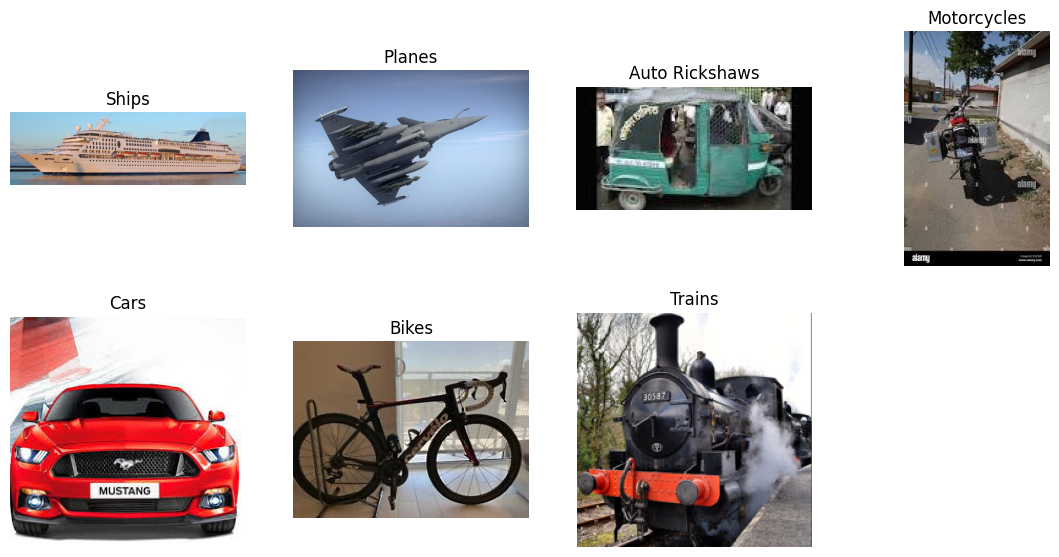

In [10]:
plot_images(images_class)

## Data Pre-processing

In [47]:
data_generator = ImageDataGenerator(rescale=1/255, 
                                    validation_split=0.2,
                                    rotation_range=30,
                                    width_shift_range=0.3,
                                    height_shift_range=0.3,
                                    brightness_range=[0.8, 1.2],
                                    zoom_range=0.3,
                                    horizontal_flip=True
                                   )

In [12]:
train_data=data_generator.flow_from_directory('/Users/sarthak/Documents/IC Project/Vehicles', 
                                              target_size=(224,224), 
                                              batch_size=32, 
                                              class_mode='categorical', 
                                              shuffle=True, 
                                              subset='training')

Found 4470 images belonging to 7 classes.


In [13]:
test_data=data_generator.flow_from_directory('/Users/sarthak/Documents/IC Project/Vehicles', 
                                             target_size=(224,224), 
                                             batch_size=32, 
                                             class_mode='categorical',
                                             shuffle=False,  # Avoid unnecessary shuffling in validation
                                             subset='validation')

Found 1117 images belonging to 7 classes.


## Defining CNN Model

In [15]:
model = Sequential()

# 1st convolution layer 
model.add(Input(shape=(224, 224, 3)))
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd convolution layer
model.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd convolutional layer
model.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

# global average pooling
model.add(GlobalAveragePooling2D())

# fully connected layers (dense layer)
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # regularization
model.add(Dense(7, activation='softmax'))  # 7 classes

In [16]:
#ensuring gpu available is utilized
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 1


## Using Exponential decay(Scheduled Learning Rate Reduction):
 - The learning rate decreases at fixed intervals using an exponential function.
 - Independent of validation loss: It does not check performance; it just decays Learning Rate based on steps.
 - Smooth decay, useful for pretraining or stable tasks.
 - May decay too fast/slow, no adjustment based on validation loss.

In [17]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay( # helps the model start with a high learning rate and adapt over time.
    initial_learning_rate=1e-3,
    decay_steps=1000,
    decay_rate=0.96,
    staircase=True
)

# compiling the model
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
print(model.summary()) #model structure

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,559 (435.78 KB)

 Trainable params: 111,111 (434.03 KB)

 Non-trainable params: 448 (1.75 KB)

None


In [19]:
from sklearn.utils.class_weight import compute_class_weight

# computing class weights to deal with class imbalance problem
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(train_data.classes),
    y = train_data.classes
)

# convert class weights to dictionary format
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

## Model Training

In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# model training
model_history = model.fit(
    train_data,
    epochs=15,
    validation_data=test_data,
    class_weight=class_weight_dict,  # Adjusts importance of each class
    callbacks=[early_stopping]
)

/Users/sarthak/Documents/IC Project/ic_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


2025-02-06 22:14:03.019719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


 87/140 ━━━━━━━━━━━━━━━━━━━━ 14s 267ms/step - accuracy: 0.2754 - loss: 2.0458

/Users/sarthak/Documents/IC Project/ic_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 346ms/step - accuracy: 0.2992 - loss: 1.9746 - val_accuracy: 0.1531 - val_loss: 2.4154
Epoch 2/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 351ms/step - accuracy: 0.4134 - loss: 1.5941 - val_accuracy: 0.1791 - val_loss: 2.2445
Epoch 3/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 52s 373ms/step - accuracy: 0.4773 - loss: 1.4697 - val_accuracy: 0.2363 - val_loss: 2.0402
Epoch 4/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 356ms/step - accuracy: 0.5136 - loss: 1.3769 - val_accuracy: 0.4047 - val_loss: 1.5561
Epoch 5/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 363ms/step - accuracy: 0.5411 - loss: 1.3282 - val_accuracy: 0.4539 - val_loss: 1.4248
Epoch 6/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 358ms/step - accuracy: 0.5727 - loss: 1.1832 - val_accuracy: 0.5855 - val_loss: 1.2016
Epoch 7/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 362ms/step - accuracy: 0.5987 - loss: 1.1364 - val_accuracy: 0.3769 - val_loss: 3.4395
Epoch 8/15
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 360ms/step - accuracy: 0.6123 - loss: 1.0803 - val

In [50]:
#saving the trained model - after first 11 epochs
model.save('/Users/sarthak/Documents/IC Project/Models/vehicle_image_classification_model.keras')

In [57]:
# running more epochs for increasing accuracy 
model_history = model.fit(
    train_data,
    epochs=10,
    validation_data=test_data,
    class_weight=class_weight_dict,  
    callbacks=[early_stopping] 
)

Epoch 1/10
 52/140 ━━━━━━━━━━━━━━━━━━━━ 24s 274ms/step - accuracy: 0.7132 - loss: 0.8542

/Users/sarthak/Documents/IC Project/ic_env/lib/python3.10/site-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 353ms/step - accuracy: 0.7230 - loss: 0.8163 - val_accuracy: 0.7108 - val_loss: 0.8102
Epoch 2/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 357ms/step - accuracy: 0.7437 - loss: 0.7274 - val_accuracy: 0.6902 - val_loss: 0.9029
Epoch 3/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 353ms/step - accuracy: 0.7492 - loss: 0.7284 - val_accuracy: 0.6688 - val_loss: 0.9962
Epoch 4/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 360ms/step - accuracy: 0.7484 - loss: 0.7422 - val_accuracy: 0.7126 - val_loss: 0.8085
Epoch 5/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 351ms/step - accuracy: 0.7585 - loss: 0.6983 - val_accuracy: 0.7592 - val_loss: 0.7491
Epoch 6/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 357ms/step - accuracy: 0.7670 - loss: 0.6571 - val_accuracy: 0.7601 - val_loss: 0.7403
Epoch 7/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 359ms/step - accuracy: 0.7753 - loss: 0.6556 - val_accuracy: 0.7413 - val_loss: 0.7280
Epoch 8/10
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 356ms/step - accuracy: 0.7831 - loss: 0.6496 - val

In [70]:
#saving the trained model state after 10 more epochs
model.save('/Users/sarthak/Documents/IC Project/Models/vehicle_image_classification_model_1_v2.keras')

In [ ]:
# to load the model in later phase
#load_model = model.save('/Users/sarthak/Documents/IC Project/Models/vehicle_image_classification_model.keras')

## Results

### After first 11 epochs

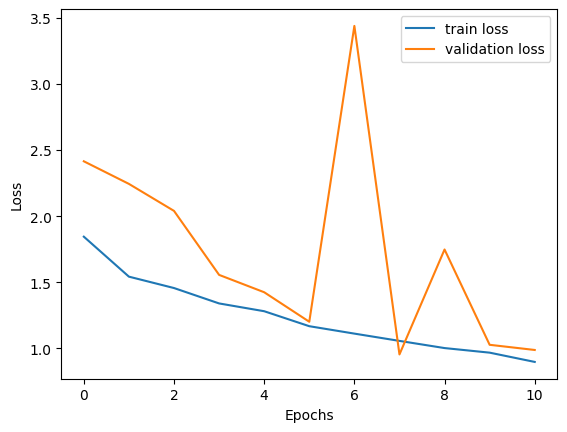

In [21]:
plt.plot(model_history.history['loss'],label='train loss')
plt.plot(model_history.history['val_loss'],label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

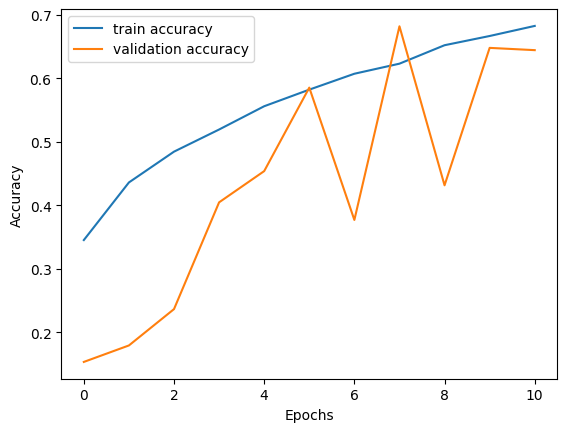

In [22]:
plt.plot(model_history.history['accuracy'],label='train accuracy')
plt.plot(model_history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### After 10 more epochs

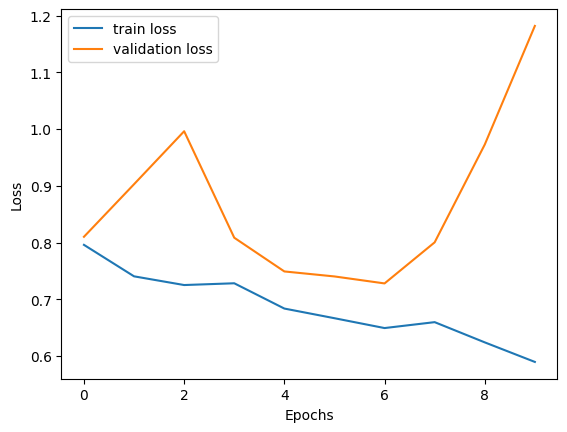

In [58]:
plt.plot(model_history.history['loss'],label='train loss')
plt.plot(model_history.history['val_loss'],label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

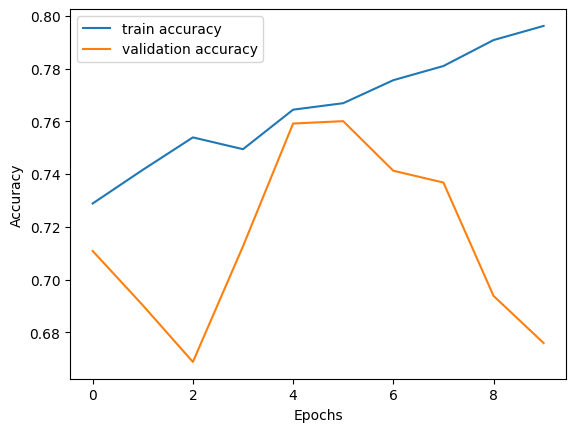

In [59]:
plt.plot(model_history.history['accuracy'],label='train accuracy')
plt.plot(model_history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

-> So it can be observe that the accuracy is decreasing, steaply after more epochs, means the model is overfitting. Means more training is effecting the model in a bad way, making it inaccurate for unseen data.

In [51]:
# evaluating the model on test data - after first 11 epochs
test_loss, test_accuracy = model.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 258ms/step - accuracy: 0.7591 - loss: 0.6686 
Test Loss: 0.7950611114501953
Test Accuracy: 0.7170993685722351


-> It can be observed that test loss is very high and test accuracy is only ~71%

In [56]:
# predict and analyze performance - after first 11 epochs
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes[test_data.index_array]

# precision and recall
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step 
Precision: 0.753232351617899
Recall: 0.7242614145031334


In [60]:
# classification report - after 11 epochs
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes))

# confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.78      0.64       160
           1       0.93      0.88      0.90       160
           2       0.55      0.68      0.60       158
           3       0.83      0.64      0.73       160
           4       0.78      0.89      0.83       159
           5       0.92      0.62      0.74       160
           6       0.72      0.59      0.65       160

    accuracy                           0.72      1117
   macro avg       0.75      0.72      0.73      1117
weighted avg       0.75      0.72      0.73      1117

Confusion Matrix:
[[124   0  22   3   1   0  10]
 [ 10 140   4   5   0   0   1]
 [ 30   3 107  11   2   1   4]
 [ 10   4  37 103   2   1   3]
 [  7   1   5   0 141   2   3]
 [  7   1   7   0  30  99  16]
 [ 37   2  14   2   5   5  95]]


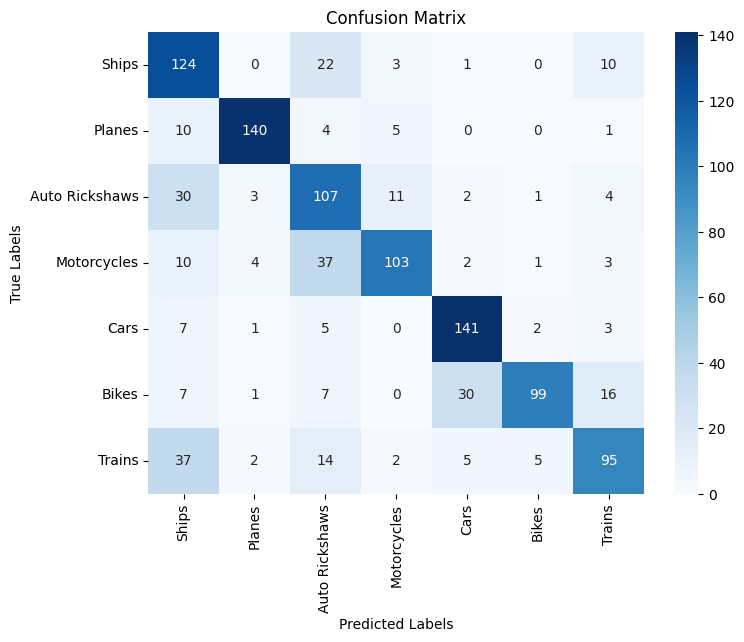

In [61]:
# graphical representation of confusion matrix - first 11 epocs
cm = confusion_matrix(y_true, y_pred_classes)

class_names = images_class

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

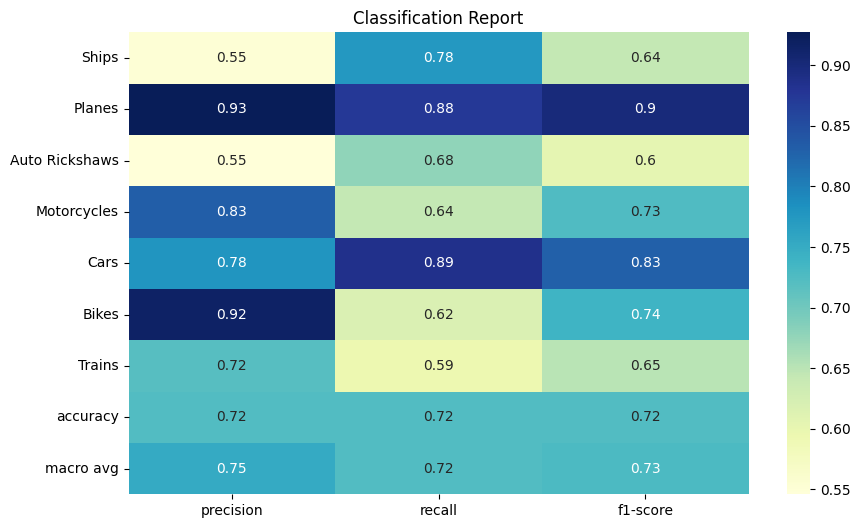

In [62]:
# graphical representation of classification report
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report).transpose()

# heatmap of classification report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', cbar=True)
plt.title('Classification Report')
plt.show()

#### -> All the metrics after 10 more epochs : To see the changes in result metrics

In [63]:
# evaluating the model on test data - after 10 more epochs
test_loss, test_accuracy = model.evaluate(test_data)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 262ms/step - accuracy: 0.7251 - loss: 0.7553 
Test Loss: 0.7092423439025879
Test Accuracy: 0.7538048624992371


In [64]:
# predict and analyze performance - after 10 more epochs
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_data.classes[test_data.index_array]

# precision and recall
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 264ms/step 
Precision: 0.7895690247606812
Recall: 0.7305282005371531


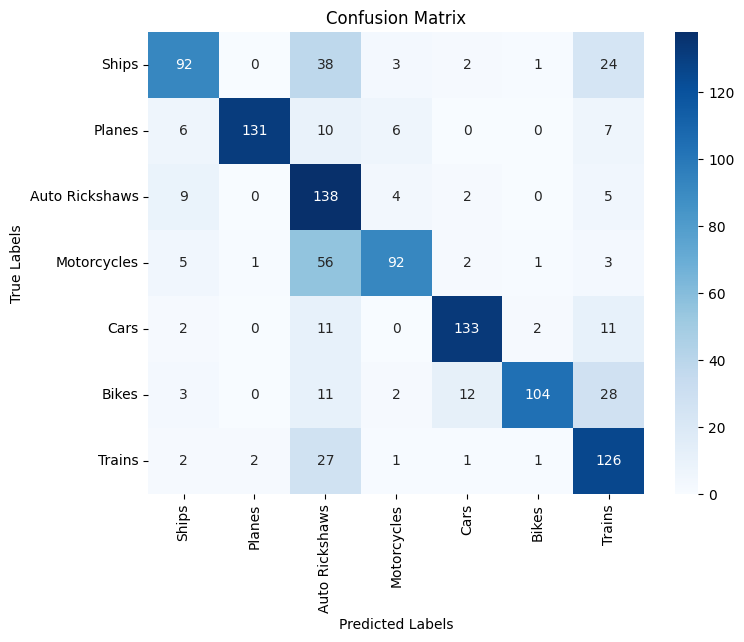

In [65]:
# graphical representation of confusion matrix - first 10 more epochs
cm = confusion_matrix(y_true, y_pred_classes)

class_names = images_class

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

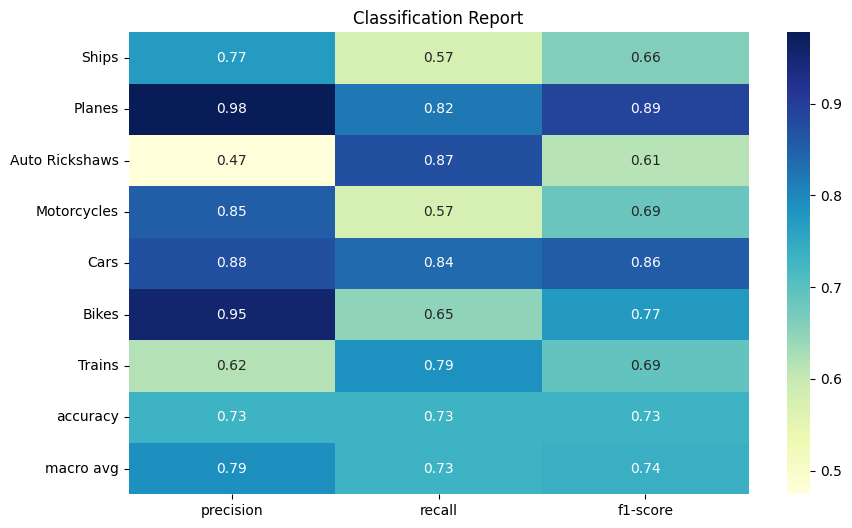

In [66]:
# graphical representation of classification report - after 10 more epochs
report = classification_report(y_true, y_pred_classes, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', cbar=True)
plt.title('Classification Report')
plt.show()

-> There are very minute improvement in the metrics, like accuracy, precision, recall, etc. Which reflects in the 2nd classification report as well. 

-> But if we compare the 1st and 2nd confusion matrix, it can clearly be observed that the model is kind of proceeding towards overfitting, and not generalizing well for new data.

## Using ReduceLROnPlateau (Adaptive Learning Rate Reduction)
- If validation loss doesn't improve for a few epochs, then the learning rate is reduced.
- It scales the learning rate down by a specified factor (e.g., 0.5 → LR becomes half).
- Patience: It waits for a certain number of epochs (patience) before reducing the LR.
- Prevents overfitting: Helps when training reaches a plateau.
- Better fine-tuning: Keeps training stable for longer.

### a new model --> model_2

In [31]:
model_2 = Sequential()

# 1st convolutional layer
model_2.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(224, 224, 3)))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# 2nd convolutional layer
model_2.add(Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# 3rd convolutional layer
model_2.add(Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model_2.add(BatchNormalization())
model_2.add(MaxPooling2D(pool_size=(2, 2)))

# global average pooling
model_2.add(GlobalAveragePooling2D())

# fully connected layers (dense layers)
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))  # Regularization
model_2.add(Dense(7, activation='softmax'))  # 7 classes

In [32]:
from tensorflow.keras.optimizers import Adam

# compiling the model
model_2.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall()])

In [33]:
print(model_2.summary())

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_4      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,559 (435.78 KB)

 Trainable params: 111,111 (434.03 KB)

 Non-trainable params: 448 (1.75 KB)

None


In [35]:
# callbacks
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=5, 
                               restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(
                monitor='val_loss', # monitoring validation loss
                factor=0.3, # reduce learning rate by 30% when triggered
                patience=3, # waits for 3 epochs of no improvement
                min_lr=1e-6) # lower limit for Learning rate

# model training
model_history_2 = model_2.fit(
    train_data,
    epochs=20,
    validation_data=test_data,
    class_weight=class_weight_dict,  # Adjusts importance of each class
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 51s 353ms/step - accuracy: 0.3119 - loss: 1.9304 - val_accuracy: 0.1737 - val_loss: 2.2426 - learning_rate: 0.0010
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 349ms/step - accuracy: 0.4340 - loss: 1.5307 - val_accuracy: 0.1674 - val_loss: 2.3146 - learning_rate: 0.0010
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 49s 352ms/step - accuracy: 0.4929 - loss: 1.4508 - val_accuracy: 0.3277 - val_loss: 1.8020 - learning_rate: 0.0010
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 52s 370ms/step - accuracy: 0.5139 - loss: 1.3621 - val_accuracy: 0.3876 - val_loss: 1.6595 - learning_rate: 0.0010
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 53s 379ms/step - accuracy: 0.5423 - loss: 1.3130 - val_accuracy: 0.5604 - val_loss: 1.2292 - learning_rate: 0.0010
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 358ms/step - accuracy: 0.5751 - loss: 1.1912 - val_accuracy: 0.4064 - val_loss: 2.1446 - learning_rate: 0.0010
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 50s 356ms/step - accuracy: 0.6

In [71]:
#saving the trained model: model_2
model_2.save('/Users/sarthak/Documents/IC Project/Models/vehicle_image_classification_model_2.keras')

## Training and Validation Plot for model_2

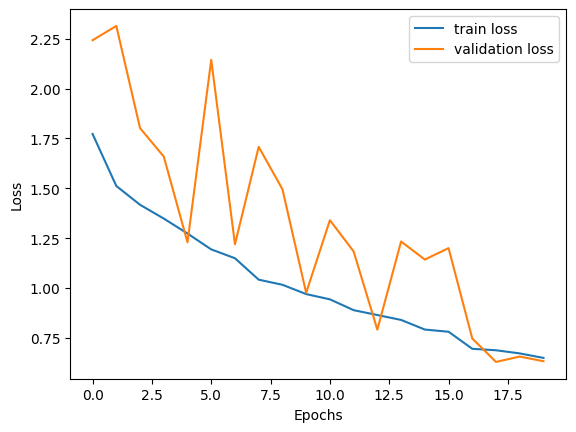

In [52]:
#training loss vs validation loss
plt.plot(model_history_2.history['loss'],label='train loss')
plt.plot(model_history_2.history['val_loss'],label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

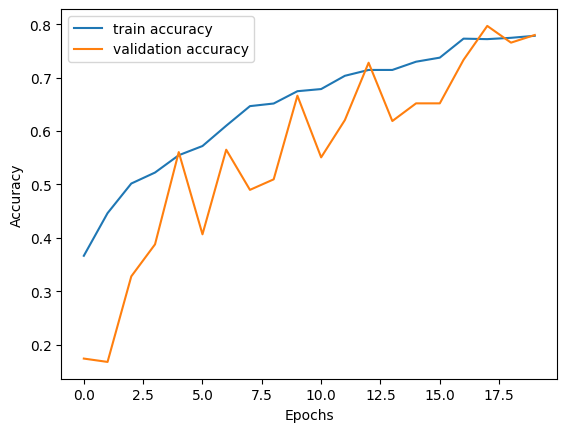

In [53]:
#training accuracy vs validation accuracy
plt.plot(model_history_2.history['accuracy'],label='train accuracy')
plt.plot(model_history_2.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [54]:
# evaluating the model on test data
test_loss_2, test_accuracy_2 = model_2.evaluate(test_data)

print(f"Test Loss: {test_loss_2}")
print(f"Test Accuracy: {test_accuracy_2}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 254ms/step - accuracy: 0.7961 - loss: 0.6477 
Test Loss: 0.6296943426132202
Test Accuracy: 0.8003581166267395


In [55]:
y_pred_2 = model_2.predict(test_data)
y_pred_classes_2 = np.argmax(y_pred_2, axis=1)  # convert softmax output to class labels
y_true_2 = test_data.classes  # true labels

# precision and recall
precision_2 = precision_score(y_true_2, y_pred_classes_2, average='weighted')
recall_2 = recall_score(y_true_2, y_pred_classes_2, average='weighted')

print(f"Precision: {precision}")
print(f"Recall: {recall}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 9s 242ms/step 
Precision: 0.760022017429341
Recall: 0.7341092211280215


-> This model is generalized better.

### Classification Report and Confusion Matrix

In [68]:
# classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_true_2, y_pred_classes_2))

# confusion matrix
from sklearn.metrics import confusion_matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true_2, y_pred_classes_2))

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.79      0.73       160
           1       0.98      0.79      0.88       160
           2       0.81      0.59      0.68       158
           3       0.70      0.93      0.80       160
           4       0.87      0.92      0.90       159
           5       0.82      0.78      0.80       160
           6       0.74      0.73      0.74       160

    accuracy                           0.79      1117
   macro avg       0.80      0.79      0.79      1117
weighted avg       0.80      0.79      0.79      1117

Confusion Matrix:
[[126   0  11   9   2   3   9]
 [  7 127   1  17   0   3   5]
 [ 27   0  93  29   0   0   9]
 [  6   0   3 148   0   1   2]
 [  3   1   1   0 146   4   4]
 [  3   1   1   2  16 125  12]
 [ 12   0   5   6   3  17 117]]


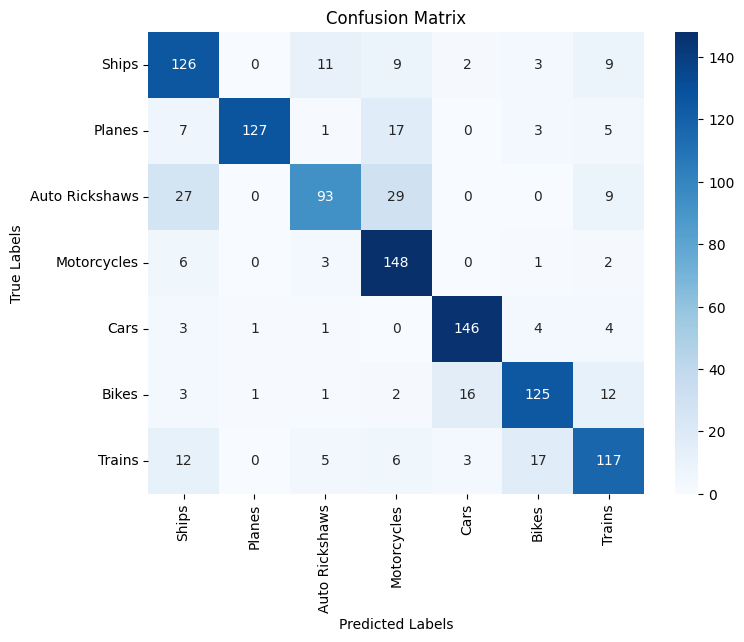

In [67]:
# confusion matrix
cm = confusion_matrix(y_true_2, y_pred_classes_2)

class_names = images_class

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

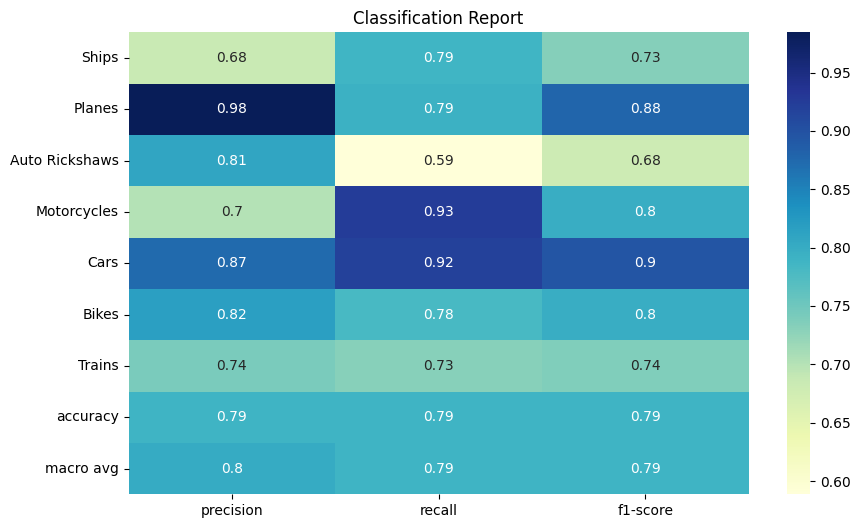

In [69]:
# classification report
report = classification_report(y_true_2, y_pred_classes_2, target_names=class_names, output_dict=True)

report_df = pd.DataFrame(report).transpose()

# heatmap of classification report
plt.figure(figsize=(10, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='YlGnBu', cbar=True)
plt.title('Classification Report')
plt.show()

#### -> The models used here are the base models with the 3 convolution layer followed by a dense layer, and the accuracy achieved here is in the optimal range that can be achieved by these model. (Optimal range is 70% - 85%)

#### -> I tried many variations in different part of the whole precess i.e. Data Pre-processing, model training, and hyper-parameter tuning, and the maximum optimal accuracy achieved was in the rance of 70% to 85%. 

#### -> To further improve the accuracy of model, some modifications need to be done in the model architecture.
#### -> Also pre-trained model can be leveraged and fine-tuned for obtaining better results.